In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd '/content/drive/MyDrive/FPT Mask /data_211/data_211/Test Code/'

/content/drive/MyDrive/FPT Mask /data_211/data_211/Test Code


In [45]:
from PIL import Image, ImageDraw
import PIL
import torch
import os
import torchvision.transforms.functional as F
import numpy as np
import random
import glob
from torchvision.utils import save_image
import string
import cv2
import ntpath

In [46]:
from utils import yolo_convert_pascal_voc, pascal_voc_convert_yolo, yolo_format_to_str, parse_annot, find_and_remove_empty_file

## Tunning Parameter

In [47]:
cwd = os.getcwd()

# please fill full path contain images, labels
source_path_image = cwd + "/data_211_big/images/train/"
source_path_anno = cwd + "/data_211_big/labels/train/"

# please fill full path contain generated images, labels
target_path_anno = cwd + '/test/cutouts_test/labels/'
target_path_img = cwd + '/test/cutouts_test/images/'

if not os.path.exists(target_path_anno):
    os.makedirs(target_path_anno)
if not os.path.exists(target_path_img):
    os.makedirs(target_path_img)

In [48]:
find_and_remove_empty_file(source_path_image)
find_and_remove_empty_file(source_path_anno)

In [49]:
#Zoom Out
# Maximum ratio between the original image and the generated image
max_scale = 2.5
# Set color background
filler = [0.485, 0.456, 0.406]

In [50]:
#Mix Up
# Min, max mixup ratio
min_lambd = 0.3
max_lambd = 0.7

In [51]:
#Cutout
# fill_val: Value filled in cut out
# bbox_remove_thres: Theshold to remove bbox cut by cutout
fill_val=0
bbox_remove_thres=0.4
min_num_of_cutout_box = 8
max_num_of_cutout_box = 11

## Function

In [52]:
def intersect(boxes1, boxes2):
    '''
        Find intersection of every box combination between two sets of box
        boxes1: bounding boxes 1, a tensor of dimensions (n1, 4)
        boxes2: bounding boxes 2, a tensor of dimensions (n2, 4)
        
        Out: Intersection each of boxes1 with respect to each of boxes2, 
             a tensor of dimensions (n1, n2)
    '''
    n1 = boxes1.size(0)
    n2 = boxes2.size(0)
    max_xy =  torch.min(boxes1[:, 2:].unsqueeze(1).expand(n1, n2, 2),
                        boxes2[:, 2:].unsqueeze(0).expand(n1, n2, 2))
    
    min_xy = torch.max(boxes1[:, :2].unsqueeze(1).expand(n1, n2, 2),
                       boxes2[:, :2].unsqueeze(0).expand(n1, n2, 2))
    inter = torch.clamp(max_xy - min_xy , min=0)  # (n1, n2, 2)
    return inter[:, :, 0] * inter[:, :, 1]  #(n1, n2)
    
def zoom_out(image, boxes, max_scale,filler):
    '''
        Zoom out image (max scale = 4)
        image: A PIL image
        boxes: bounding boxes, a tensor of dimensions (#objects, 4)
        
        Out: new_image, new_boxes
    '''
    if type(image) == PIL.Image.Image:
        image = F.to_tensor(image)
    original_h = image.size(1)
    original_w = image.size(2)
    scale = random.uniform(1, max_scale)
    new_h = int(scale*original_h)
    new_w = int(scale*original_w)
    
    #Create an image with the filler
    filler = torch.FloatTensor(filler) #(3)
    new_image = torch.ones((3, new_h, new_w), dtype= torch.float) * filler.unsqueeze(1).unsqueeze(1)
    

    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    
    new_image[:, top:bottom, left:right] = image
    
    #Adjust bounding box
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(0)
    
    return new_image, new_boxes


def cut_out(image, boxes, labels, fill_val=0, bbox_remove_thres=0.4):
    '''
        Cutout augmentation
        image: A PIL image
        boxes: bounding boxes, a tensor of dimensions (#objects, 4)
        labels: labels of object, a tensor of dimensions (#objects)

        Out: new image, new_boxes, new_labels
    '''
    if type(image) == PIL.Image.Image:
        image = F.to_tensor(image)
    original_h = image.size(1)
    original_w = image.size(2)
    original_channel = image.size(0)

    new_image = image
    new_boxes = boxes
    new_labels = labels

    for _ in range(50):
        # Random cutout size: [0.15, 0.5] of original dimension
        cutout_size_h = random.uniform(0.05 * original_h, 0.05 * original_h)
        cutout_size_w = random.uniform(0.05 * original_w, 0.05 * original_w)

        # Random position for cutout
        left = random.uniform(0, original_w - cutout_size_w)
        right = left + cutout_size_w
        top = random.uniform(0, original_h - cutout_size_h)
        bottom = top + cutout_size_h
        cutout = torch.FloatTensor([int(left), int(top), int(right), int(bottom)])

        # Calculate intersect between cutout and bounding boxes
        overlap_size = intersect(cutout.unsqueeze(0), boxes)
        area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        ratio = overlap_size / area_boxes
        # If all boxes have Iou greater than bbox_remove_thres, try again
        if ratio.min().item() > bbox_remove_thres:
            continue

        cutout_arr = torch.full((original_channel, int(bottom) - int(top), int(right) - int(left)), fill_val)
        new_image[:, int(top):int(bottom), int(left):int(right)] = cutout_arr

        # Create new boxes and labels
        boolean = ratio < bbox_remove_thres

        new_boxes = boxes[boolean[0], :]

        new_labels = labels[boolean[0]]

        return new_image, new_boxes, new_labels

def mixup(image_info_1, image_info_2, lambd):
    '''
        Mixup 2 image

        image_info_1, image_info_2: Info dict 2 image with keys = {"image", "label", "box"}
        lambd: Mixup ratio

        Out: mix_image (Temsor), mix_boxes, mix_labels
    '''
    img1 = image_info_1["image"]  # Tensor
    img2 = image_info_2["image"]  # Tensor
    mixup_width = max(img1.shape[2], img2.shape[2])
    mix_up_height = max(img1.shape[1], img2.shape[1])

    mix_img = torch.zeros(3, mix_up_height, mixup_width)
    mix_img[:, :img1.shape[1], :img1.shape[2]] = img1 * lambd
    mix_img[:, :img2.shape[1], :img2.shape[2]] += img2 * (1. - lambd)

    mix_labels = torch.cat((image_info_1["label"], image_info_2["label"]), dim=0)

    mix_boxes = torch.cat((image_info_1["box"], image_info_2["box"]), dim=0)

    return mix_img, mix_boxes, mix_labels

## Generate Image

In [53]:
path_image_list = glob.glob(source_path_image + "/*.jpg")
path_anno_list = glob.glob(source_path_anno+ "/*.txt")

img_name = [ntpath.basename(path).split(".")[0] for path in path_image_list]
anno_name = [ntpath.basename(path).split(".")[0] for path in path_anno_list]
# find image have not anno
for i in img_name:
    if i not in anno_name:
        img_name.remove(i)
path_image_list = [source_path_image + f"/{i}.jpg" for i in img_name]

### Zoom Out

In [54]:
for image_path in path_image_list:
    # Read image
    image = Image.open(image_path, mode= "r")
    image = image.convert("RGB")

    # Get anno file from image path
    objects= parse_annot(image_path, source_path_anno)
    boxes = torch.FloatTensor(objects['boxes'])
    labels = torch.LongTensor(objects['labels']) 

    # Zoom Out
    new_image, new_boxes = zoom_out(image, boxes, max_scale, filler)

    # Generate random string
    random_string = ''.join(random.choices(string.ascii_lowercase + string.digits, k=12))
    _,h,w = new_image.shape

    # Convert pascal voc to yolo format
    boxes = pascal_voc_convert_yolo(new_boxes, labels, w,h)

    # Merge all bouding box
    anno_bbox = yolo_format_to_str(boxes)

    name_file_anno = target_path_anno + "zoom_out_" + random_string
    name_file_images = target_path_img + "zoom_out_" + random_string

    f = open(name_file_anno + ".txt", 'w')
    f.write(anno_bbox)
    f.close()

    save_image(new_image, name_file_images + ".jpg")

### CutOut

In [55]:
for image_path in path_image_list:
    # Read image
    image = Image.open(image_path, mode= "r")
    image = image.convert("RGB")

    # Get anno file from image path
    objects= parse_annot(image_path, source_path_anno)
    boxes = torch.FloatTensor(objects['boxes'])
    labels = torch.LongTensor(objects['labels']) 


    new_image = image
    new_boxes = boxes
    new_labels = labels
    #Cutout
    num_cutout_box = random.randint(min_num_of_cutout_box,max_num_of_cutout_box)
    for i in range(num_cutout_box):
        new_image,new_boxes, new_labels = cut_out(new_image, new_boxes,new_labels, fill_val, bbox_remove_thres)

    # Generate random string
    random_string = ''.join(random.choices(string.ascii_lowercase + string.digits, k=12))
    _,h,w = new_image.shape

    # Convert pascal voc to yolo format
    boxes = pascal_voc_convert_yolo(new_boxes, new_labels, w,h)

    # Merge all bouding box
    anno_bbox = yolo_format_to_str(boxes)

    name_file_anno = target_path_anno + "cut_out_" + random_string
    name_file_images = target_path_img + "cut_out_" + random_string

    f = open(name_file_anno + ".txt", 'w')
    f.write(anno_bbox)
    f.close()

    save_image(new_image, name_file_images + ".jpg")

### MixUp

In [56]:
for image_path in path_image_list:
    
    # Random path
    image_path1 = random.choice(path_image_list)
    image = Image.open(image_path, mode= "r")
    image = image.convert("RGB")

    image1 = Image.open(image_path1, mode= "r")
    image1 = image1.convert("RGB")

    objects = parse_annot(image_path, source_path_anno)
    objects_1 = parse_annot(image_path1, source_path_anno)

    image_info_1 = {"image": F.to_tensor(image), "label": torch.Tensor(objects['labels']), "box": torch.Tensor(objects['boxes'])}
    image_info_2 = {"image": F.to_tensor(image1), "label": torch.Tensor(objects_1['labels']), "box": torch.Tensor(objects_1['boxes'])}

    lambd = random.uniform(min_lambd, max_lambd)
    new_image,new_boxes, new_labels = mixup(image_info_1, image_info_2, lambd)

    random_string = ''.join(random.choices(string.ascii_lowercase + string.digits, k=12))
    _,h,w = new_image.shape

    # Convert pascal voc to yolo format
    boxes = pascal_voc_convert_yolo(new_boxes, new_labels, w,h)

    # Merge all bouding box
    anno_bbox = yolo_format_to_str(boxes)

    name_file_anno = target_path_anno + "mix_up_" + random_string
    name_file_images = target_path_img + "mix_up_" + random_string

    f = open(name_file_anno + ".txt", 'w')
    f.write(anno_bbox)
    f.close()

    save_image(new_image, name_file_images + ".jpg")

## Visual Images

In [57]:
img_paths_gen = glob.glob(target_path_img + "/*.jpg")

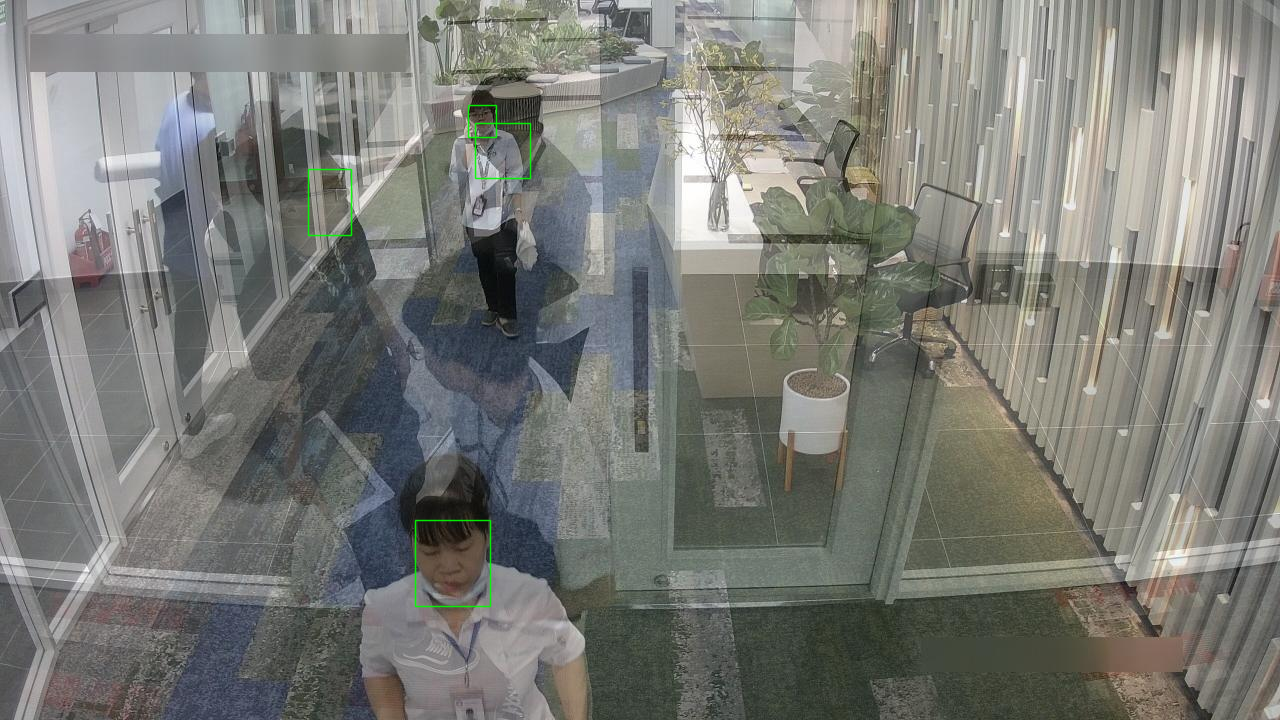

In [58]:
random_index = random.randint(0, len(img_paths_gen)-1)
img_path_gen = img_paths_gen[random_index]
objects= parse_annot(img_path_gen, target_path_anno)
bbox = objects['boxes']

image = cv2.imread(img_path_gen)

for anno_ in bbox:
    start_point = (int(anno_[0]), int(anno_[1]))
    end_point = (int(anno_[2]), int(anno_[3]))
    cv2.rectangle(image, start_point, end_point, (0, 255, 0), 1, cv2.LINE_AA)

new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
new_image = Image.fromarray(new_image.astype(np.uint8))
new_image